In [16]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
from py_pol.jones_matrix import Jones_matrix
from py_pol.jones_vector import Jones_vector
from py_pol.mueller import Mueller

from py_pol import degrees

import matplotlib.pyplot as plt

from py_aocg.SLM_system import cargar_Jones_SLM, SLM_system_field
from py_aocg.ifta.algorithms import distances_scalar

In [26]:
np.set_printoptions(precision=1)

In [1]:
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.single.local_best import LocalBestPSO
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
from pyswarms.utils.plotters.formatters import Mesher

py_aocg
number of processors: 8
total memory        : 15.5 Gb
available memory    : 61 %
max frequency       : 3100 GHz
number of processors: 8
total memory        : 15.5 Gb
available memory    : 61 %
max frequency       : 3100 GHz


## Cargar Matrices de polarización de Holoeye

In [2]:
S_incident=Jones_vector('incident')
S_incident.circular_light(intensity=2)

Jslm=cargar_Jones_SLM(type="Jones")

In [3]:
size_x_DOE, size_y_DOE = 15,15
doe_real = np.linspace(-1,1, size_x_DOE)
doe_imag = np.linspace(-1,1, size_y_DOE)

DOE_real, DOE_imag = np.meshgrid(doe_real, doe_imag)

DOE = DOE_real + 1j*DOE_imag

In [4]:
def cost_function_distances(angles, Jslm, S_incident):
    """ Cost function to obtain a properly SLM phase configuration 
    
    Args:
        angles: (np.ndarray): Rotation angles of P1, Q1, Q2 and P2.
        Jslm: (Jones_matrix): Jones matrix of the SLM.
        S_incident (Jones_vector): Illumination
        
    Returns:
        cost: (float): Value of merit function of a SLM phase configuration
        
    """

    u_fab_amplitude, u_fab_phase, fields=SLM_system_field(angles, Jslm, E0=S_incident)

    # Normalizar
    # u_fab_amplitude = u_fab_amplitude / u_fab_amplitude.max()
    u_fab = u_fab_amplitude*np.exp(1j*u_fab_phase)
    u_fab_real =u_fab[::5].real
    u_fab_imag =u_fab[::5].imag
    
    DOE_new, i_positions, distances=distances_scalar(DOE, u_fab)
    
    cost = distances.mean()
    # cost = np.linalg.norm(distances)
    
    return cost

In [5]:
def optimization_loop(angles,Jslm, S_incident, optimize_function):
    """
    Optimization loop of the particules of PySwarms algorithm.
    
    Args:
        angles: (np.ndarray): Rotation angles of P1, Q1, Q2 and P2.
        Jslm: (Jones_matrix): Jones matrix of the SLM.
        optimize_function (function): Function to optimize.
    
    Returns:
        cost: (float): Value of merit function
    
    """
    num_particles = angles.shape[0]
    cost = [cost_function_distances(angles[i,:],Jslm, S_incident) for i in range(num_particles)]
    
    return cost

In [6]:
Jslm = cargar_Jones_SLM()
print(Jslm.shape)

[256]


In [7]:
options = {'c1': 0.5, 'c2': 0.6, 'w': 0.9}
# options = {'c1': 0.5, 'c2': 0.5, 'w': 0.5}
dimensions = 4
min_bound = np.zeros(dimensions); max_bound = np.ones(dimensions)*360*degrees
bounds = (min_bound, max_bound)

iters=100
n_particles=100

In [8]:
optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=options, bounds=bounds)

In [9]:
%%time 
cost, angles = optimizer.optimize(optimization_loop,iters,Jslm=Jslm, S_incident=S_incident ,optimize_function=cost_function_distances)

2021-11-18 17:06:25,166 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.6, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.269
2021-11-18 17:08:39,625 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.26854775923431834, best pos: [4.3347012  2.47036505 2.99119476 4.86310778]


CPU times: user 2min 14s, sys: 123 ms, total: 2min 14s
Wall time: 2min 14s


In [10]:
print(angles/degrees)

[248.36008439 141.54149102 171.38283564 278.63555118]


- best cost: 0.21199592361665928, best pos: [1.63644037 5.11863528 2.7111866  1.68529409]
- best cost: 0.21164481754171188, best pos: [1.61038889 1.947723   2.66072842 4.8141105 ]

In [11]:
 u_fab_amplitude, u_fab_phase, fields=SLM_system_field(angles, Jslm, E0=S_incident)

In [12]:
# Normalizar
# u_fab_amplitude = u_fab_amplitude / u_fab_amplitude.max()
u_fab = u_fab_amplitude*np.exp(1j*u_fab_phase)
u_fab_real =u_fab[::5].real
u_fab_imag =u_fab[::5].imag

DOE_new, i_positions, distances=distances_scalar(DOE, u_fab)

In [13]:
print(i_positions)

[[113 113 104  91  91  86  78  73  68  63  58  56  51  48  48]
 [113 113 108 104  91  91  78  73  68  63  56  53  48  48  44]
 [113 113 113 104  99  91  82  75  65  59  53  48  48  44  42]
 [129 119 113 113 104  96  85  76  66  54  51  46  45  42  42]
 [137 129 129 119 112 106  92  79  55  50  47  42  42  40  40]
 [139 137 137 129 125 110 100  79  52  43  39  39  38  37  37]
 [150 148 148 143 135 126 110 110  35  35  35  34  34   0   0]
 [157 157 157 154 154 154 146  10  10  10  24  28   0   0   0]
 [168 168 168 165 165 165 165   1   1   1   1  18 255 255 255]
 [174 174 179 181 185 190 205   1   1   1   1 255 255 255 255]
 [184 188 188 194 198 205 222 243 251 253 254 254 255 255 255]
 [192 195 197 204 211 221 230 243 249 251 253 254 254 254 254]
 [197 203 204 210 220 227 235 243 248 251 253 253 254 254 254]
 [204 204 210 220 225 229 239 242 248 250 252 253 253 254 254]
 [210 215 220 225 225 233 239 242 246 249 252 252 253 253 254]]


In [27]:
print(distances)

[[0.8 0.7 0.6 0.5 0.4 0.4 0.3 0.3 0.3 0.4 0.4 0.5 0.6 0.7 0.8]
 [0.7 0.6 0.5 0.4 0.3 0.2 0.2 0.2 0.2 0.2 0.3 0.4 0.5 0.6 0.7]
 [0.6 0.5 0.4 0.3 0.2 0.1 0.1 0.1 0.1 0.1 0.2 0.3 0.4 0.5 0.6]
 [0.5 0.4 0.3 0.2 0.1 0.  0.1 0.1 0.1 0.  0.1 0.2 0.3 0.4 0.5]
 [0.5 0.3 0.2 0.1 0.  0.1 0.2 0.2 0.2 0.1 0.  0.1 0.2 0.3 0.5]
 [0.4 0.3 0.1 0.  0.1 0.2 0.3 0.4 0.3 0.2 0.1 0.  0.2 0.3 0.4]
 [0.4 0.2 0.1 0.  0.2 0.3 0.4 0.5 0.4 0.3 0.1 0.  0.1 0.2 0.4]
 [0.3 0.2 0.1 0.1 0.2 0.3 0.5 0.5 0.4 0.2 0.1 0.  0.1 0.2 0.3]
 [0.4 0.2 0.1 0.1 0.2 0.3 0.5 0.5 0.3 0.2 0.  0.1 0.1 0.2 0.3]
 [0.4 0.2 0.1 0.  0.2 0.3 0.4 0.5 0.4 0.2 0.1 0.1 0.  0.2 0.3]
 [0.4 0.3 0.1 0.  0.1 0.2 0.3 0.4 0.4 0.3 0.2 0.1 0.2 0.2 0.3]
 [0.4 0.3 0.2 0.1 0.1 0.1 0.2 0.3 0.2 0.2 0.1 0.  0.1 0.3 0.4]
 [0.5 0.4 0.3 0.1 0.  0.  0.1 0.1 0.1 0.  0.1 0.1 0.2 0.3 0.4]
 [0.6 0.5 0.4 0.2 0.2 0.1 0.  0.  0.1 0.1 0.1 0.2 0.3 0.4 0.5]
 [0.7 0.6 0.4 0.4 0.3 0.2 0.2 0.2 0.2 0.2 0.3 0.3 0.4 0.5 0.6]]


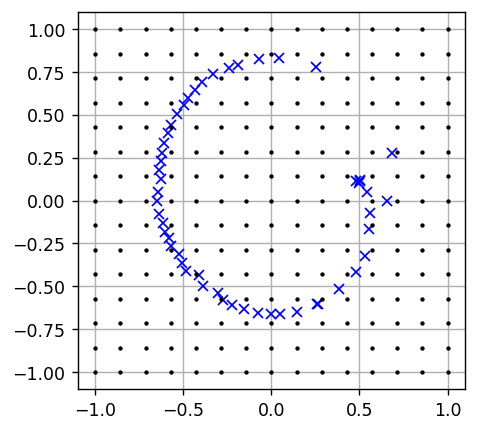

In [15]:
plt.figure()
plt.plot(u_fab_real, u_fab_imag, 'bx', ms=6)
plt.plot(DOE_real, DOE_imag, 'k.', ms=3)
plt.grid(True)